# Mensaausgaben 👨‍🍳🍳🍽️

In [ ]:
import pandas as pd
import numpy as np
import delicardservice as ds
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
cardNr = "123456"
password = "abcd"
ds.scrapeDelicardApi(cardNr,password)
ds.mergeDataDumps(cardNr, True)
data: pd.DataFrame = ds.getDataframe(cardNr)

Data already cached...
request: GET https://ks.stwpb.de:2342/TL1/TLM/KASVC/TRANSPOS?datumBis=13.11.2025&datumVon=16.08.2025&format=JSON&karteNr=138596, response: 200 (25.76 KiB), created: 2025-11-12 15:52:39 Mitteleuropäische Zeit, expires: 2025-11-13 15:52:39 Mitteleuropäische Zeit (fresh)
request: GET https://ks.stwpb.de:2342/TL1/TLM/KASVC/TRANS?datumBis=13.11.2025&datumVon=16.08.2025&format=JSON&karteNr=138596, response: 200 (9.77 KiB), created: 2025-11-12 15:52:39 Mitteleuropäische Zeit, expires: 2025-11-13 15:52:39 Mitteleuropäische Zeit (fresh)
Data download successful!


In [17]:
data

datum      ortName         kaName  typName   
transFullId posId                                                            
10-3419-37  1     2022-12-08 11:36:00    Cafeteria   Cafeteria 10  Verkauf  \
            2     2022-12-08 11:36:00    Cafeteria   Cafeteria 10  Verkauf   
            3     2022-12-08 11:36:00    Cafeteria   Cafeteria 10  Verkauf   
7-4003-599  1     2022-12-08 12:58:00        Mensa   Mensakasse 7  Verkauf   
            2     2022-12-08 12:58:00        Mensa   Mensakasse 7  Verkauf   
...                               ...          ...            ...      ...   
36-1278-411 4     2025-11-11 13:45:00  Mensa Forum  Kasse Forum 2  Verkauf   
            5     2025-11-11 13:45:00  Mensa Forum  Kasse Forum 2  Verkauf   
            6     2025-11-11 13:45:00  Mensa Forum  Kasse Forum 2  Verkauf   
4-1607-708  1     2025-11-12 13:53:00        Mensa   Mensakasse 4  Verkauf   
            2     2025-11-12 13:53:00        Mensa   Mensakasse 4  Verkauf   

                   zahlBetrag  dateiablageId                  name  menge   
transFullId posId                                                           
10-3419-37  1           -3.50            NaN    Kaffee, Pfandtasse      1  \
            2           -3.50            NaN      Tassenpfand plus      1   
            3           -3.50            NaN   Brötchen mit Salami      1   
7-4003-599  1           -4.40            NaN     Stamm HK Essen 10      2   
            2           -4.40            NaN  Tafelwasser 0,3l Gl.      1   
...                       ...            ...                   ...    ...   
36-1278-411 4           -8.25      1262248.0     Counter Dessert 2      1   
            5           -8.25      1262248.0               Ketchup      1   
            6           -8.25      1262248.0  Tafelwasser 0,2l Gl.      1   
4-1607-708  1           -4.90      1270608.0   Aktionsessen 4,90 €      1   
            2           -4.90      1270608.0  Tafelwasser 0,3l Gl.      1   

                   epreis  gpreis  rabatt  
transFullId posId                          
10-3419-37  1        1.20    1.20     NaN  
            2        1.00    1.00     NaN  
            3        1.30    1.30     NaN  
7-4003-599  1        2.20    4.40     NaN  
            2        0.30    0.00     0.3  
...                   ...     ...     ...  
36-1278-411 4        1.50    1.50     NaN  
            5        0.15    0.15     NaN  
            6        0.20    0.00     0.2  
4-1607-708  1        4.90    4.90     NaN  
            2        0.30    0.00     0.3  

[2303 rows x 11 columns]

## Datenaufbereitung 🔧🧹

In [18]:
### Remove STORNO entries
data.drop(columns=["dateiablageId"], inplace=True)
stornoedIds = data[data["name"].str.contains("STORNO")]

# Iterate through the STORNO entries
for storno_index, storno_row in stornoedIds.iterrows():
    # Extract the name without "STORNO" prefix
    original_name = storno_row["name"].replace("STORNO ", "")
    
    # Find the matching entry in the same transaction
    transaction_id = storno_index[0]  # TransFullId
    matching_entries = data.loc[transaction_id]
    # Multiple positions of the same product are not always summarized into a single position with a quantity greater than 1
    matching_index = matching_entries.index[matching_entries["name"] == original_name] # posIds possibly matching the STORNO entry
    if not matching_index.empty:
        matching_index = matching_index[0]
        matching_row = data.loc[(transaction_id, matching_index)]
        if matching_row["menge"].size == 1:
            if storno_row["menge"] == -matching_row["menge"].item():
                assert storno_row["gpreis"] == -matching_row["gpreis"].item()
                # Remove both STORNO and matching entries
                data.drop([storno_index, (transaction_id, matching_index)], inplace=True)
            else:
                # Adjust the "menge" and "gpreis" of the matching entry
                data.at[(transaction_id, matching_index), "menge"] += storno_row["menge"]
                data.at[(transaction_id, matching_index), "gpreis"] += storno_row["gpreis"]
                
                # Remove the STORNO entry
                data.drop(storno_index, inplace=True)
        else:
            print(f"Skipping entry {storno_index} due to ambiguous match.")
    else:
        print(f"No matching entry found for STORNO at index {storno_index}.")

# FIXME: TransFullId contains duplicate posIds due to the renaming of a facility

# data.loc["10-3644-109"]

# datum	ortName	kaName	typName	zahlBetrag	name	menge	epreis	gpreis	rabatt
# posId										
# 1	2023-06-16 10:55:00	Mensa Forum	Cafeteria 10	Verkauf	0.0	Dinkelcrusty belegt	1	2.0	2.0	NaN
# 1	2023-06-16 10:55:00	Cafeteria	Cafeteria 10	Verkauf	0.0	Dinkelcrusty belegt	1	2.0	2.0	NaN
# 2	2023-06-16 10:55:00	Mensa Forum	Cafeteria 10	Verkauf	0.0	STORNO Dinkelcrusty belegt	-1	2.0	-2.0	NaN
# 2	2023-06-16 10:55:00	Cafeteria	Cafeteria 10	Verkauf	0.0	STORNO Dinkelcrusty belegt	-1	2.0	-2.0	NaN

##### Datasets for further usage

# Positions with spendings (no balance top-ups)
data_spendings = data[~data["name"].isin(["Karte aufwerten","Aufwertung"])]

# Position with spendings for fixed price items only (no items billed by weight)
data_fixed_prices = data_spendings[~data_spendings["name"].str.contains("Stamm Eintopf|Rabatt Mittagessen|Antipastibuffet")]

Skipping entry ('10-3644-109', 2) due to ambiguous match.
Skipping entry ('10-3644-109', 2) due to ambiguous match.


## Statistiken & Insights 📈🧾

In [19]:
print(f"Verfügbarer Datenzeitraum: {data['datum'].min().date().strftime('%d.%m.%Y')} bis {data['datum'].max().date().strftime('%d.%m.%Y')}")

Verfügbarer Datenzeitraum: 08.12.2022 bis 12.11.2025


### Produkte & Preise 🛍️💶

#### Preisänderungen 💸📈

In [20]:
priceIncreasings = data_fixed_prices.groupby("name").agg(increase=("epreis", lambda x: x.max() - x.min()), min=("epreis", "min"), max=("epreis", "max")).sort_values(by=("increase"), ascending=False)
priceIncreasings = priceIncreasings[priceIncreasings["increase"] != 0]
if priceIncreasings.empty: print("No price increases.")
priceIncreasings

,increase,min,max
name,,,
Latte Macchiato,0.90,1.00,1.90
Brötchen mit Salami,0.40,1.30,1.70
Milchkaffee,0.20,1.90,2.10
Eggekerni Salami,0.20,2.00,2.20
Cappuccino,0.20,1.80,2.00
Muffin Blaubeer,0.20,1.50,1.70
"Mio Mio Mate 0,5l",0.20,1.25,1.45
"Coca Cola 0,5l Fl. zzgl. Pfand",0.15,1.50,1.65
"Josefs Orange 0,5l Fl. zzgl. Pfand",0.10,1.25,1.35


#### Teuerste Käufe 🪙💎

In [21]:
data_spendings.sort_values(by="epreis", ascending=False).head(5)

,,datum,ortName,kaName,typName,zahlBetrag,name,menge,epreis,gpreis,rabatt
transFullId,posId,,,,,,,,,,
7-4075-546,1,2023-04-05 13:30:00,Mensa,Mensakasse 7,Verkauf,-8.2,"Aktionsessen 6,35 €",1,6.35,6.35,NaN
5-2698-467,2,2023-02-10 13:02:00,Mensa,Mensakasse 5,Verkauf,-6.7,"Aktionsessen 5,90 €",1,5.90,5.90,NaN
5-2751-271,2,2023-04-28 12:37:00,Mensa,Mensakasse 5,Verkauf,-6.7,"Aktionsessen 5,90 €",1,5.90,5.90,NaN
4-1018-260,1,2023-04-27 12:12:00,Mensa,Mensakasse 4,Verkauf,-7.4,"Aktionsessen 5,90 €",1,5.90,5.90,NaN
7-4143-161,1,2023-07-21 11:50:00,Mensa,Mensakasse 7,Verkauf,-5.9,"Aktionsessen 5,90 €",1,5.90,5.90,NaN


#### Letzte bekannte Preise 🏷️💰

In [52]:
aktionsessenFilter = data_fixed_prices["name"].str.contains(r"Aktionsessen \d+,?\d*\s?€") # well, Aktionsessen 2,50€ obviously costs 2.50€... This is boring
data_fixed_prices[~aktionsessenFilter].sort_values(by="datum", ascending=True).groupby("name").last().sort_values(by="name")[["datum", "epreis"]]

,datum,epreis
name,,
Annabelle Classic 1l Fl. zzgl. Pfand,2024-08-20 13:54:00,1.15
Annabelle Medium 1l Fl. zzgl. Pfand,2024-03-13 14:20:00,1.15
Black Donut,2024-11-05 13:50:00,1.10
Blechkuchen,2024-09-03 12:41:00,1.50
"Bowl 4,20 €",2023-05-11 12:20:00,4.20
...,...,...
"Trinkschokolade, Pfandtasse",2023-02-16 14:54:00,1.20
Vytal Schale,2023-10-18 13:34:00,0.00
"Wok 3,50 €",2023-05-04 11:53:00,3.50


### Persönliches Ausgabeverhalten 💳🙂

#### Häufigste Käufe 🛒📊

In [23]:
top_by_menge = data_spendings.groupby("name")["menge"].sum().sort_values(ascending=False).head(10).to_frame()
top_by_menge.rename(columns={"menge": "Anzahl"}, inplace=True)
top_by_menge

,Anzahl
name,
"Tafelwasser 0,3l Gl.",292
Tassenpfand plus,148
Tassenpfand minus,145
Stamm Sättigungsbeilage 1,100
Stamm Beilagensalat,97
Stamm Dessert,92
Counter Dessert 1,89
"Aktionsessen 3,80 €",75
"Tafelwasser 0,2l Gl.",74


### Fun Facts & Kurioses 🍴😄

In [ ]:
from typing import Tuple
import datetime


def format_euro(value: float) -> str:
    """Gibt einen float als formatierten Euro-String zurück (z. B. 1.234,56€)."""
    return "{:,.2f}€".format(value)


def sum_and_df(df, pattern: str, *, col: str = "gpreis", case: bool = False) -> Tuple[float, "pd.DataFrame"]:
    """Sucht nach `pattern` in der Spalte `name` und gibt (summe, dataframe) zurück.
    `case=False` macht den Search case-insensitive.
    """
    mask = df["name"].str.contains(pattern, case=case, na=False)
    sub = df[mask]
    return sub[col].sum(), sub

spendings_sum = data_spendings["gpreis"].sum()
autoload_sum = data[data["name"].str.contains("Karte aufwerten|Aufwertung", case=False, na=False)]["gpreis"].sum()

print("💸 Insgesamt wurden", format_euro(spendings_sum), "ausgegeben")
print("🔋 Aufgeladenes Guthaben:", format_euro(autoload_sum))
print()
print("📊 Ausgaben nach Kategorie:")

CATEGORIES = {
    "Getränke": {
        "pattern": r"Kaffee|Tee|Trinkschokolade|Cappuccino|Café Creme|Milchkaffee|Latte Macchiato|Cafe au Lait|Mio Mio|Cola|Red Bull|effect|Annabelle|Carolinen|Josefs|Cafe",
        "count_col": "menge",
        "emoji": "☕️",
        "case_insensitive": True,
    },
    "Brötchen/Snacks in der Cafeteria": {
        "pattern": r"Brötchen|Dinkelmalzbrötchen|Körnerdreick|Saatenecke|Eggekerni|Milka|Dinkelcrusty|Kartoffelbrötchen|Dinkelbr|Muffin|Maxi-Laugen-Butter-Gipfel|Donut|Laugen|Blaubeer|Butterlaugenecke|Pute|Schinken|Salami|Gouda|Nogger|brötchen",
        "count_col": "menge",
        "emoji": "🥐",
        "case_insensitive": True,
    },
    "Hauptgerichte in der Mensa": {
        "pattern": r"Stamm|Aktionsessen|Ketchup|Mayo|Pommes",
        "aggregate": "days",
        "emoji": "🍽️",
    },
    "Salatteller (Antipastibuffet)": {
        "pattern": r"Antipastibuffet",
        "count_col": "menge",
        "emoji": "🥗",
    },
    "Pastatheke-Teller (Nudelbuffet)": {
        "pattern": r"Pastatheke",
        "count_col": "menge",
        "emoji": "🍝",
    },
    "Desserts insgesamt": {
        "pattern": r"Dessert|kuchen",
        "count_col": "menge",
        "emoji": "🍰",
    },
    "Joghurt (Stamm Dessert)": {
        "pattern": r"Stamm Dessert",
        "count_col": "menge",
        "emoji": "🥣",
    },
    "Sonstige Desserts": {
        "pattern": r"Counter Dessert|Blechkuchen",
        "count_col": "menge",
        "emoji": "🧁",
    },
}

for label, cfg in CATEGORIES.items():
    pattern = cfg.get("pattern", "")
    case = cfg.get("case_insensitive", False)
    total, subset = sum_and_df(data, pattern, col="gpreis", case=case)
    emoji = cfg.get("emoji", "")

    if cfg.get("aggregate") == "days":
        # Anzahl Tage mit Mensabesuch (ein Tag zählt einmal)
        if subset.empty:
            days = 0
        else:
            days = subset.groupby(subset.datum.dt.date)["datum"].nunique().shape[0]
        print(f"  {emoji} - {format_euro(total)} für {label} an {days} Tagen")
    else:
        count_col = cfg.get("count_col")
        if count_col and not subset.empty:
            amount = int(subset[count_col].sum())
            print(f"  {emoji} - {format_euro(total)} für {amount} {label}")
        else:
            print(f"  {emoji} - {format_euro(total)} für {label}")

print()
print("💡 Fun Facts:")

# Besuchstage und Durchschnittsausgaben pro Besuchstag
daily = data_spendings.resample("D", on="datum")["gpreis"].sum()
visit_days = (daily > 0).sum()
if visit_days > 0:
    avg_per_visit = daily[daily > 0].mean()
    print(f"  📅 Besuchstage insgesamt: {visit_days} | Ø Ausgaben pro Besuchstag: {format_euro(avg_per_visit)}")
else:
    print("  📅 Keine Besuchstage in den Daten gefunden.")

# Größter einzelner Einkauf
try:
    tx_sums = data_spendings.groupby(level=0)["gpreis"].sum()
    if not tx_sums.empty:
        biggest_tx_sum = tx_sums.max()
        biggest_tx_id = tx_sums.idxmax()
        # Datum des größten Einkaufs
        try:
            tx_date = data_spendings.loc[biggest_tx_id].datum.iloc[0].date()
            print(f"  🏆 Größter Einkauf: {format_euro(biggest_tx_sum)} am {tx_date}")
        except Exception:
            print(f"  🏆 Größter Einkauf: {format_euro(biggest_tx_sum)}")
    else:
        print("  🏆 Keine Transaktionen gefunden.")
except Exception:
    print("  🏆 Größter Einkauf: Konnte nicht berechnet werden (Indexstruktur unbekannt).")

# Teuerster Einzelartikel (nach epreis)
if not data_spendings.empty and "epreis" in data_spendings.columns:
    top_item = data_spendings.sort_values("epreis", ascending=False).head(1)
    if not top_item.empty:
        item_name = top_item.iloc[0]["name"]
        item_price = top_item.iloc[0]["epreis"]
        print(f"  💎 Teuerstes gekauftes Angebot: '{item_name}' für {format_euro(item_price)}")

# Lieblingsort (nach Gesamtausgaben)
if not data_spendings.empty and "ortName" in data_spendings.columns:
    try:
        fav_place = data_spendings.groupby("ortName")["gpreis"].sum()
        fav_place_name = fav_place.idxmax()
        fav_place_amount = fav_place.max()
        print(f"  🏠 Lieblingsort: {fav_place_name} — {format_euro(fav_place_amount)} insgesamt")
    except Exception:
        pass

# Längste aufeinanderfolgende Besuchsserie (Tage)
dates = sorted(data_spendings["datum"].dt.date.unique())
longest = 0
if dates:
    current = 1
    prev = dates[0]
    for d in dates[1:]:
        if d == prev + datetime.timedelta(days=1):
            current += 1
        else:
            if current > longest:
                longest = current
            current = 1
        prev = d
    longest = max(longest, current)
    print(f"  🔁 Längste Besuchsserie: {longest} Tage in Folge")
else:
    print("  🔁 Keine Besuchsdaten für die Serie gefunden.")

# Tassenpfand (nicht zurückgegebene Tassen)
mugs_plus = data_spendings[data_spendings["name"].str.contains("Tassenpfand plus", na=False)]["menge"].sum()
mugs_minus = data_spendings[data_spendings["name"].str.contains("Tassenpfand minus", na=False)]["menge"].sum()
not_returned = int(mugs_plus - mugs_minus)
print(f"  ☕️ Tassenpfand - Nicht zurückgegebene Tassen: {not_returned}")

💸 Insgesamt wurden 2,850.05€ ausgegeben
🔋 Aufgeladenes Guthaben: 2,840.00€

📊 Ausgaben nach Kategorie:
  ☕️ - 307.20€ für 215 Getränke
  🥐 - 282.20€ für 174 Brötchen/Snacks in der Cafeteria
  🍽️ - 1,914.40€ für Hauptgerichte in der Mensa an 430 Tagen
  🥗 - 91.00€ für 45 Salatteller (Antipastibuffet)
  🍝 - 5.60€ für 2 Pastatheke-Teller (Nudelbuffet)
  🍰 - 309.10€ für 249 Desserts insgesamt
  🥣 - 73.60€ für 92 Joghurt (Stamm Dessert)
  🧁 - 235.50€ für 157 Sonstige Desserts

💡 Fun Facts:
  📅 Besuchstage insgesamt: 443 | Ø Ausgaben pro Besuchstag: 6.43€
  🏆 Größter Einkauf: 9.75€ am 2024-10-17
  💎 Teuerstes gekauftes Angebot: 'Aktionsessen 6,35 €' für 6.35€
  🏠 Lieblingsort: Mensa — 1,574.00€ insgesamt
  🔁 Längste Besuchsserie: 5 Tage in Folge
  ☕️ Tassenpfand - Nicht zurückgegebene Tassen: 3


In [25]:
# Spendings by facility
print("Ausgaben nach Ort 🏠:")
mensa = data_spendings[["ortName", "menge", "gpreis", "rabatt"]].groupby("ortName").sum()
mensa

Ausgaben nach Ort 🏠:


,menge,gpreis,rabatt
ortName,,,
Bona Vista,64,12.20,0.00
Cafeteria,163,119.70,0.00
Mensa,1053,1574.00,76.42
Mensa Forum,665,696.70,17.60
Mensa ZM2,227,436.05,7.20
Picknick,17,11.40,0.00


### Grafiken & Trends 📊✨

#### Ausgaben‑Trends 📆📉📈

Die Gesamtausgaben sinken um durchschnittlich 16.2% pro Jahr.
Die Kosten für Mittagessen steigen um durchschnittlich 10.45% pro Jahr.


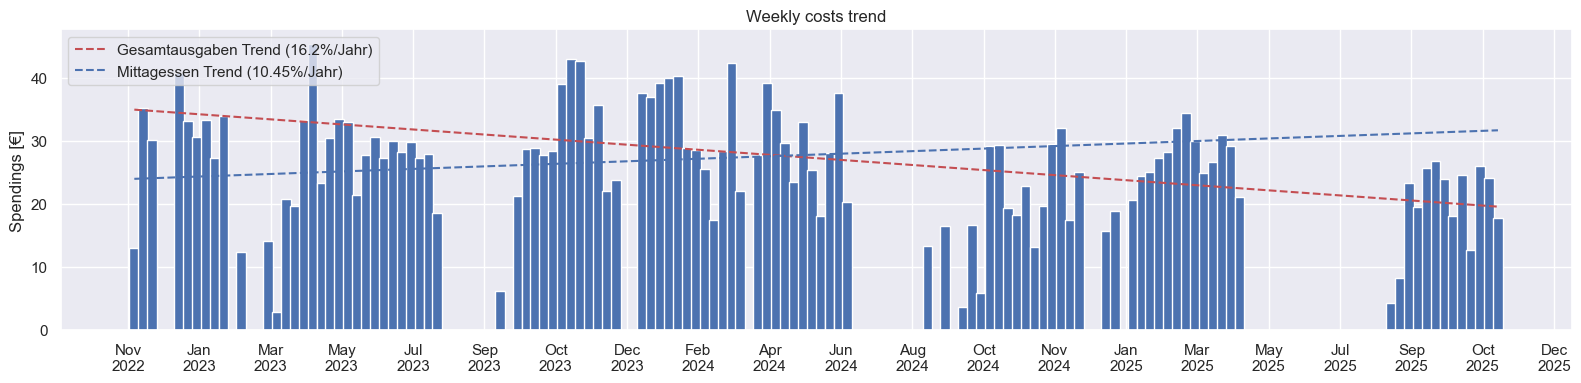

In [26]:
import matplotlib.dates as mdates
from typing import Optional, Tuple

def trend_text(slope: float, typ: str, annual_pct: float) -> str:
    verb = "steigen" if slope >= 0 else "sinken"
    print(f"Die {typ} {verb} um durchschnittlich {round(annual_pct, 2)}% pro Jahr.")

def compute_weekly_resampled(df, date_col: str = "datum", price_col: str = "gpreis", week_label: str = "W-SUN") -> "pd.DataFrame":
    # woche | gpreis | tage
    daily = df.resample("D", on=date_col)[price_col].sum()
    weekly = daily.resample(week_label, label="left").agg(gpreis="sum", tage=lambda s: (s > 0).sum())
    return weekly

def fit_trend_for_series(series: "pd.Series") -> Tuple[Optional[np.poly1d], Optional[float]]:
    if series is None or series.empty:
        return None, None
    x = np.arange(len(series.index))
    if len(x) == 1:
        coeffs = np.array([0.0, series.values[0]])
    else:
        coeffs = np.polyfit(x, series.values, 1)
    p = np.poly1d(coeffs)
    slope = coeffs[0]
    mean = series.mean()
    pct_per_year = abs(slope * 52.14 / mean * 100) if mean != 0 else 0.0
    return p, pct_per_year

def plot_weekly_trends(weekly_df: "pd.DataFrame", lunch_df: "pd.DataFrame") -> None:
    # Plot: Balken + Trendlinien für Gesamt und Mittagessen
    global weeklyResampled, weeklycosts, lunchWeeklyResampled, weeklycostsLaunch
    weeklyResampled = weekly_df.copy()
    weeklycosts = weeklyResampled["gpreis"]
    lunchWeeklyResampled = lunch_df.copy()
    weeklycostsLaunch = lunchWeeklyResampled["gpreis"]

    fig, ax = plt.subplots(figsize=(16,4))
    ax.bar(weeklycosts.index, weeklycosts.values, width=max(0.01, 0.05*len(weeklycosts.index)))
    ax.set(title="Weekly costs trend", ylabel="Spendings [€]")

    # X-Achse: weniger Labels bei vielen Wochen
    unique_weeks = pd.to_datetime(weeklycosts.index.to_period("W").to_timestamp()).unique()
    interval = max(1, (len(unique_weeks) + 19) // 20)
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=interval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b\n%Y"))

    # Trendberechnung: nur volle Wochen (tage == 5) betrachten
    weekly_trend_series = weeklyResampled[weeklyResampled["tage"] == 5]["gpreis"]
    p_all, pct_all = fit_trend_for_series(weekly_trend_series)
    if p_all is not None:
        ax.plot(weeklycosts.index, p_all(np.arange(len(weeklycosts.index))), "r--", label=f"Gesamtausgaben Trend ({round(pct_all,2)}%/Jahr)")

    # Mittagessen-Trend
    lunch_trend_series = lunchWeeklyResampled[lunchWeeklyResampled["tage"] == 5]["gpreis"]
    p_lunch, pct_lunch = fit_trend_for_series(lunch_trend_series)
    if p_lunch is not None:
        ax.plot(weeklycosts.index, p_lunch(np.arange(len(weeklycosts.index))), "b--", label=f"Mittagessen Trend ({round(pct_lunch,2)}%/Jahr)")

    ax.legend(loc="upper left")
    plt.tight_layout()

    # Kurztexte ausgeben
    if p_all is not None:
        trend_text(p_all.coefficients[0], "Gesamtausgaben", pct_all)
    else:
        print("Keine ausreichenden Daten für Gesamtausgaben-Trend.")
    if p_lunch is not None:
        trend_text(p_lunch.coefficients[0], "Kosten für Mittagessen", pct_lunch)
    else:
        print("Keine ausreichenden Daten für Mittagessen-Trend.")

weekly = compute_weekly_resampled(data_spendings)
lunch_mask = data_spendings["name"].str.contains("Stamm|Aktionsessen|Antipastibuffet|Pastatheke|Ketchup|Dessert|Tafelwasser|Pommes", na=False)
lunch_df = compute_weekly_resampled(data_spendings[lunch_mask])
plot_weekly_trends(weekly, lunch_df)

#### Mittagsessen-Zeit ⏰🍲

In [27]:
data_lunch = data_spendings[lunch_mask]
launchDays = data_lunch.groupby(data_lunch["datum"].dt.date).agg({"datum": "first", "ortName":"first", "gpreis": "sum", "menge": "sum"}) # Filter out multiple visits of the Mensa

launchDays["time"] = launchDays["datum"].dt.floor("10Min").dt.time
launchDays.drop("datum", axis=1, inplace=True)

timeAndLocationGroups = launchDays.groupby(["time","ortName"]).agg(visits=("ortName","count"), revenue=("gpreis","sum"))
unstackedTaL = timeAndLocationGroups.unstack(fill_value=0)

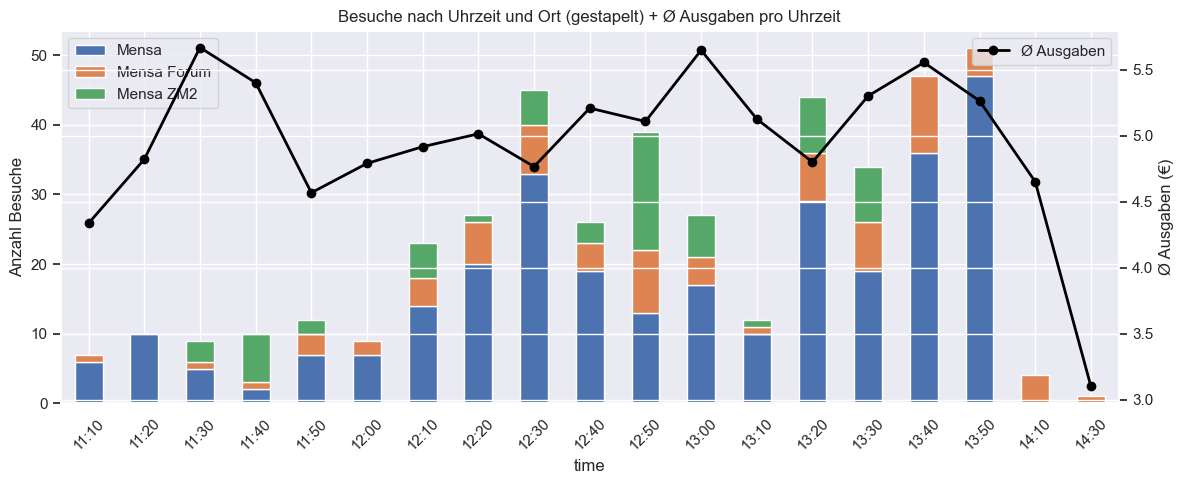

In [28]:
# Bar plot der Besuche nach Uhrzeit und Ort (gestapelt) + Durchschnittsausgaben pro Uhrzeit
visits = unstackedTaL['visits'].sort_index()
# Durchschnittsausgaben pro Uhrzeit
avg_spend = launchDays.groupby('time')['gpreis'].mean().reindex(visits.index).fillna(0)

ax = visits.plot(kind='bar', stacked=True, figsize=(12,5), ylabel='Anzahl Besuche')
ax2 = ax.twinx()
ax2.plot(range(len(avg_spend)), avg_spend.values, color='black', marker='o', linewidth=2, label='Ø Ausgaben')
ax2.set_ylabel('Ø Ausgaben (€)')

ax.set_xticklabels([t.strftime('%H:%M') if hasattr(t,'strftime') else str(t) for t in visits.index], rotation=45)
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('Besuche nach Uhrzeit und Ort (gestapelt) + Ø Ausgaben pro Uhrzeit')
plt.tight_layout()
plt.show()


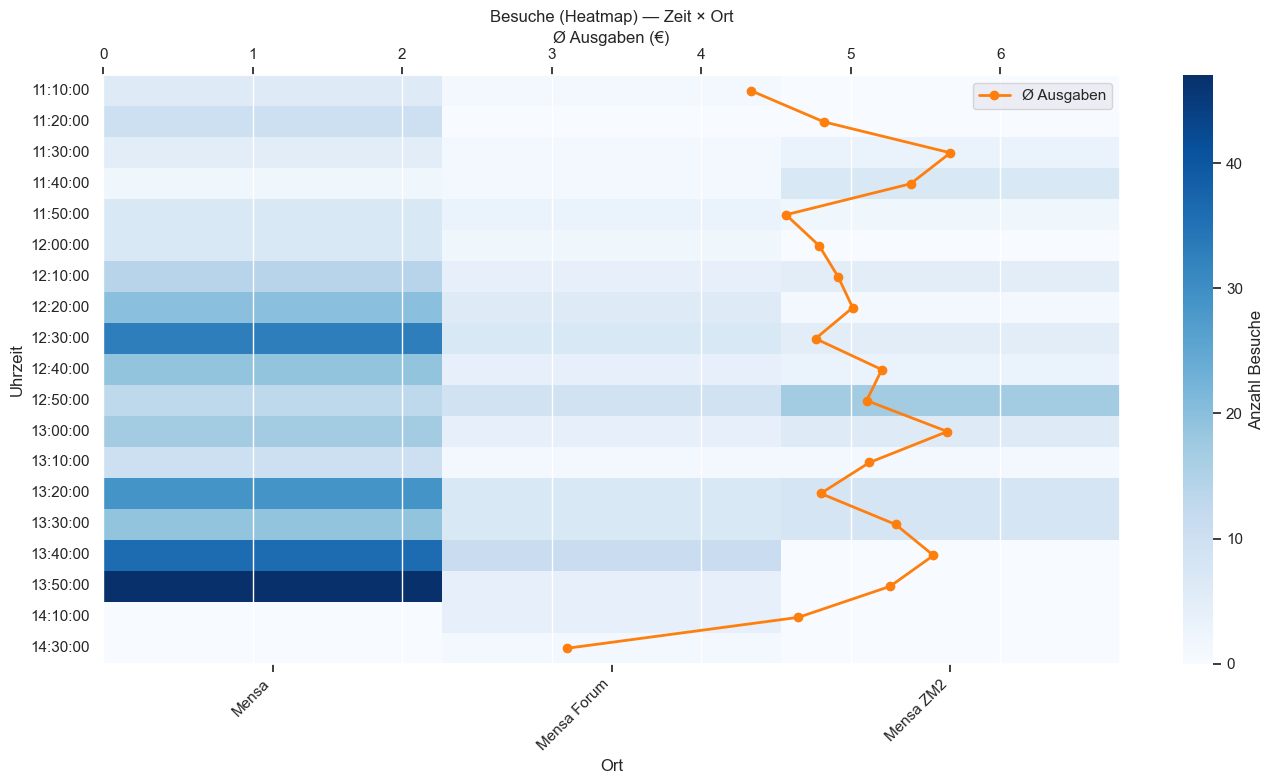

In [29]:
# Heatmap (Zeit x Ort) mit Ø Ausgaben überlagert
try:
    pivot_visits = timeAndLocationGroups['visits'].unstack(fill_value=0)
    # Sortiere Zeiten chronologisch
    pivot_visits = pivot_visits.sort_index()

    fig, ax = plt.subplots(figsize=(14,8))
    sns.heatmap(pivot_visits, cmap='Blues', ax=ax, cbar_kws={'label':'Anzahl Besuche'})
    ax.set_title('Besuche (Heatmap) — Zeit × Ort')
    ax.set_ylabel('Uhrzeit')

    # Durchschnittsausgaben pro Uhrzeit (entsprechend den Zeilen der Heatmap)
    avg_spend_by_time = launchDays.groupby('time')['gpreis'].mean().reindex(pivot_visits.index).fillna(0)

    # Neue X-Achse teilen, die die Ø Ausgaben darstellt (teilt y-Achse mit heatmap)
    ax2 = ax.twiny()

    # y-Positionen passend zu den Heatmap-Zeilen (zentrale Positionen)
    y_pos = np.arange(len(pivot_visits.index)) + 0.5

    ax2.plot(avg_spend_by_time.values, y_pos, marker='o', color='tab:orange', linewidth=2, label='Ø Ausgaben')
    ax2.set_xlabel('Ø Ausgaben (€)')

    # Achsenlimits an die Heatmap anpassen
    ax2.set_ylim(ax.get_ylim())
    # optional: etwas Platz rechts
    ax2.set_xlim(0, max(1.2 * avg_spend_by_time.max(), 1.0))

    # Legende auf der oberen Achse
    ax2.legend(loc='upper right')

    # X-Tick-Labels der unteren Achse (Ort-Namen) drehen für Lesbarkeit
    ax.set_xlabel('Ort')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.show()
except Exception as e:
    print('Fehler in aktualisierter Heatmap-Variante:', e)


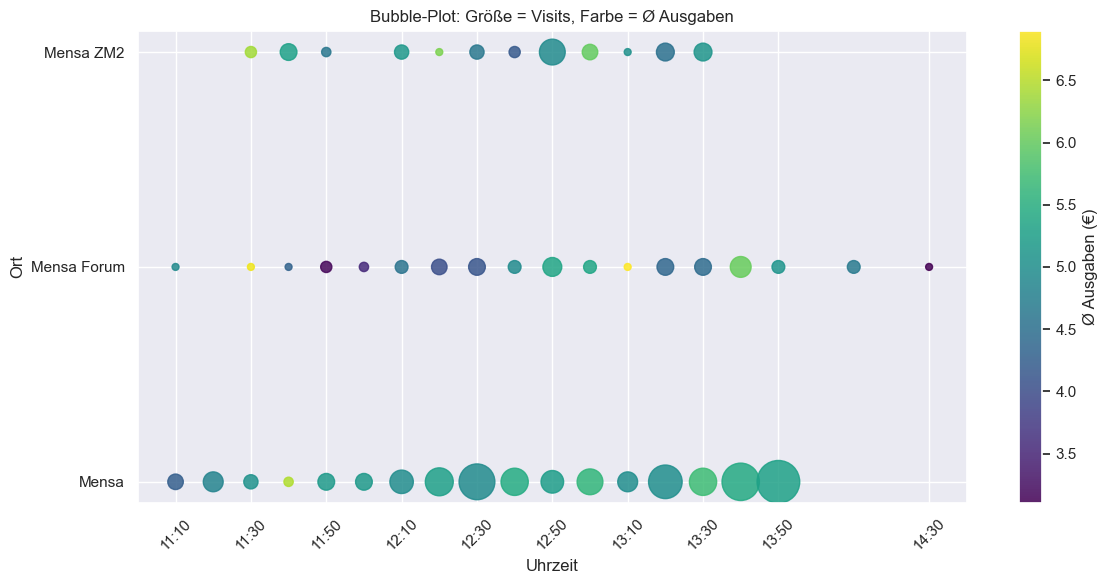

In [30]:
# Bubble-Plot (Größe = Visits, Farbe = Ø Ausgaben)
# Berechnet Visits + Revenue pro (time, ort) und zeigt alle Dimensionen in einem Scatter
try:
    tl = timeAndLocationGroups.reset_index()
    tl = tl.copy()
    tl['avg'] = tl['revenue'] / tl['visits']

    # Zeit in Minuten seit Mitternacht für X-Achse
    def time_to_min(t):
        return (t.hour * 60 + t.minute) if hasattr(t, 'hour') else int(t)  # fallback
    tl['time_min'] = tl['time'].apply(time_to_min)

    # Ordinale Y-Werte für Orte (Kategorie → Codes)
    tl['ort_code'] = tl['ortName'].astype('category').cat.codes
    ort_labels = dict(enumerate(tl['ortName'].astype('category').cat.categories))

    plt.figure(figsize=(12,6))
    sc = plt.scatter(x=tl['time_min'], y=tl['ort_code'], s=tl['visits'] * 20 + 5, c=tl['avg'], cmap='viridis', alpha=0.85)
    cbar = plt.colorbar(sc)
    cbar.set_label('Ø Ausgaben (€)')

    # X-Ticks: nur einige Zeitlabels zur Lesbarkeit
    unique_times = sorted(tl['time_min'].unique())
    xticks = unique_times[::max(1, len(unique_times)//8)]
    plt.xticks(xticks, [f"{m//60:02d}:{m%60:02d}" for m in xticks], rotation=45)

    plt.yticks(list(ort_labels.keys()), list(ort_labels.values()))
    plt.xlabel('Uhrzeit')
    plt.ylabel('Ort')
    plt.title('Bubble-Plot: Größe = Visits, Farbe = Ø Ausgaben')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print('Fehler in Variante 3 (Bubble-Plot):', e)
